# Proyecto de Clasificación de Sitios Phishing

## Análisis y Clasificación de Sitios Web Phishing usando Naive Bayes

Este notebook implementa un sistema completo de clasificación para detectar sitios web de phishing utilizando el algoritmo Gaussian Naive Bayes.

**Objetivo**: Entrenar un modelo de clasificación que pueda distinguir entre sitios web legítimos (-1) y sitios de phishing (1) basándose en 30 características específicas.

**Dataset**: Training Dataset.arff - contiene 31 columnas (30 features + 1 Result)

**Fases del proyecto**:
1. Análisis inicial y carga de datos
2. División de datos (70/15/15)
3. Modelo base sin optimización
4. Optimización de hiperparámetros
5. Comparación de resultados


## 1. Configuración Inicial e Importación de Librerías

En esta sección importamos todas las librerías necesarias y configuramos la semilla aleatoria para garantizar la reproducibilidad de los resultados.


In [1]:
# ============================================
# Importación de Librerías
# ============================================

# Manejo de datos
import pandas as pd
import numpy as np
from scipy.io import arff

# División y validación de datos
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# Modelo de clasificación
from sklearn.naive_bayes import GaussianNB

# Métricas de evaluación
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
import warnings
warnings.filterwarnings('ignore')

# ============================================
# Configuración de Reproducibilidad
# ============================================
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("✓ Librerías importadas correctamente")
print(f"✓ Semilla aleatoria configurada: {RANDOM_STATE}")


✓ Librerías importadas correctamente
✓ Semilla aleatoria configurada: 42


## 2. Fase 1 y 2: Carga y Análisis del Dataset

En esta fase realizamos:
1. Carga del archivo ARFF
2. Verificación de la estructura de datos (31 columnas: 30 features + Result)
3. Verificación de tipos de datos numéricos
4. Confirmación de ausencia de valores nulos
5. Análisis de la distribución de clases


In [2]:
# ============================================
# Carga del Dataset ARFF
# ============================================

# Cargar el archivo ARFF
archivo_dataset = '../../phishing+websites/Training Dataset.arff'
data, meta = arff.loadarff(archivo_dataset)

# Convertir a DataFrame de pandas
df = pd.DataFrame(data)

# Convertir bytes a strings si es necesario y ajustar tipos
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str)

# Convertir todas las columnas a tipo numérico
df = df.apply(pd.to_numeric, errors='coerce')

print("=" * 60)
print("INFORMACIÓN DEL DATASET")
print("=" * 60)
print(f"\n📊 Dimensiones del dataset: {df.shape}")
print(f"   - Filas (muestras): {df.shape[0]:,}")
print(f"   - Columnas (features + target): {df.shape[1]}")
print(f"\n✓ Features: 30")
print(f"✓ Variable objetivo: Result (columna 31)")

# Mostrar primeras filas
print("\n" + "=" * 60)
print("PRIMERAS 5 FILAS DEL DATASET")
print("=" * 60)
display(df.head())


INFORMACIÓN DEL DATASET

📊 Dimensiones del dataset: (11055, 31)
   - Filas (muestras): 11,055
   - Columnas (features + target): 31

✓ Features: 30
✓ Variable objetivo: Result (columna 31)

PRIMERAS 5 FILAS DEL DATASET


,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [3]:
# ============================================
# Verificación de Tipos de Datos
# ============================================

print("=" * 60)
print("VERIFICACIÓN DE TIPOS DE DATOS")
print("=" * 60)

# Información de tipos
print("\nTipos de datos por columna:")
print(df.dtypes.value_counts())

# Verificar que Result tenga valores correctos
print(f"\n✓ Valores únicos en 'Result': {sorted(df['Result'].unique())}")
print(f"  Interpretación: -1 = Legítimo, 1 = Phishing")

# Asegurar que Result sea tipo int
df['Result'] = df['Result'].astype(int)

print(f"\n✓ Tipo de dato de Result: {df['Result'].dtype}")
print("✓ Todas las columnas son numéricas")


VERIFICACIÓN DE TIPOS DE DATOS

Tipos de datos por columna:
int64    31
Name: count, dtype: int64

✓ Valores únicos en 'Result': [np.int64(-1), np.int64(1)]
  Interpretación: -1 = Legítimo, 1 = Phishing

✓ Tipo de dato de Result: int64
✓ Todas las columnas son numéricas


In [4]:
# ============================================
# Verificación de Valores Faltantes
# ============================================

print("=" * 60)
print("VERIFICACIÓN DE VALORES FALTANTES")
print("=" * 60)

valores_nulos = df.isnull().sum()
total_nulos = valores_nulos.sum()

print(f"\nTotal de valores nulos en el dataset: {total_nulos}")

if total_nulos == 0:
    print("✓ No hay valores faltantes en el dataset")
    print("✓ Los datos están completos y listos para el modelado")
else:
    print("\n⚠ Se encontraron valores nulos:")
    print(valores_nulos[valores_nulos > 0])


VERIFICACIÓN DE VALORES FALTANTES

Total de valores nulos en el dataset: 0
✓ No hay valores faltantes en el dataset
✓ Los datos están completos y listos para el modelado


ANÁLISIS DE DISTRIBUCIÓN DE CLASES

Distribución de la variable objetivo (Result):
Result
-1    4898
 1    6157
Name: count, dtype: int64

Porcentajes:
  Legítimo (-1): 44.31%
  Phishing (1): 55.69%


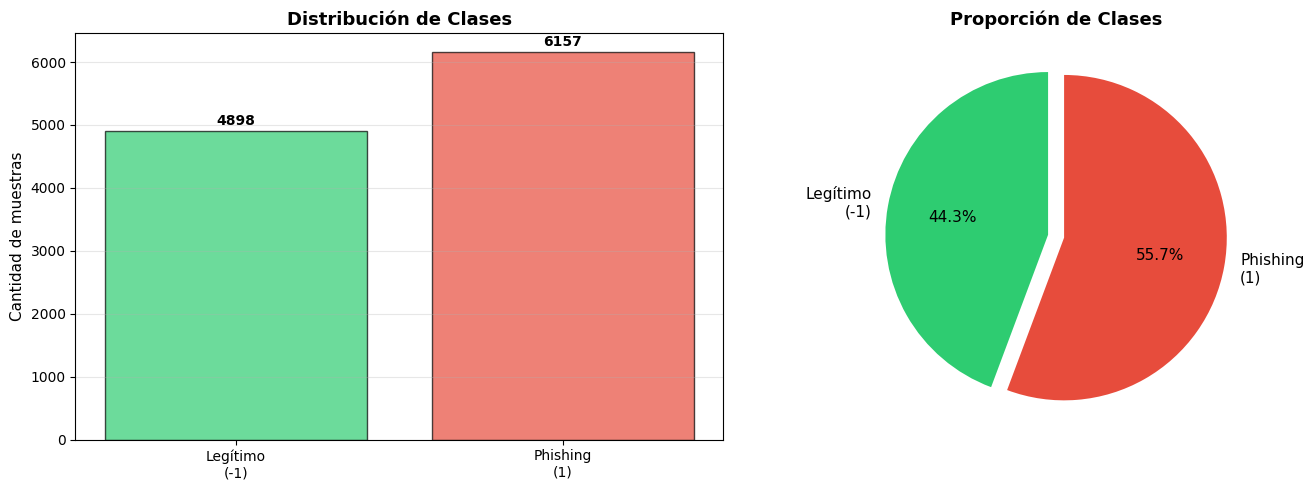


📊 Ratio de balance: 0.8
   (Clase minoritaria / Clase mayoritaria)

✓ Las clases están BALANCEADAS (ratio ≥ 0.8)
  • La clase minoritaria tiene al menos el 80% del tamaño de la mayoritaria
  • No se requieren técnicas especiales de balanceo
  • La división estratificada es suficiente


In [5]:
# ============================================
# Análisis de Distribución de Clases
# ============================================

print("=" * 60)
print("ANÁLISIS DE DISTRIBUCIÓN DE CLASES")
print("=" * 60)

# Contar distribución
distribucion = df['Result'].value_counts().sort_index()
print("\nDistribución de la variable objetivo (Result):")
print(distribucion)

# Calcular porcentajes
porcentajes = df['Result'].value_counts(normalize=True).sort_index() * 100
print("\nPorcentajes:")
for valor, porcentaje in porcentajes.items():
    etiqueta = "Legítimo" if valor == -1 else "Phishing"
    print(f"  {etiqueta} ({valor}): {porcentaje:.2f}%")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
etiquetas = ['Legítimo\n(-1)', 'Phishing\n(1)']
colores = ['#2ecc71', '#e74c3c']
axes[0].bar(etiquetas, distribucion.values, color=colores, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Cantidad de muestras', fontsize=11)
axes[0].set_title('Distribución de Clases', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(distribucion.values):
    axes[0].text(i, v + 50, str(v), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Gráfico de torta
axes[1].pie(distribucion.values, labels=etiquetas, colors=colores, autopct='%1.1f%%',
            startangle=90, textprops={'fontsize': 11}, explode=(0.05, 0.05))
axes[1].set_title('Proporción de Clases', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# Evaluación de balance
ratio = min(distribucion.values) / max(distribucion.values)
ratio = round(ratio, 2)
print(f"\n📊 Ratio de balance: {ratio}")
print(f"   (Clase minoritaria / Clase mayoritaria)")

# Interpretación del ratio con niveles
if ratio >= 0.8:
    print("\n✓ Las clases están BALANCEADAS (ratio ≥ 0.8)")
    print("  • La clase minoritaria tiene al menos el 80% del tamaño de la mayoritaria")
    print("  • No se requieren técnicas especiales de balanceo")
    print("  • La división estratificada es suficiente")
elif ratio >= 0.5:
    print("\n⚠ DESBALANCE MODERADO (0.5 ≤ ratio < 0.8)")
    print("  • Considerar: pesos de clase o validación estratificada")
    print("  • Monitorear métricas en clases minoritarias")
else:
    print("\n❌ DESBALANCE SIGNIFICATIVO (ratio < 0.5)")
    print("  • Considerar técnicas de balanceo: SMOTE, undersampling")
    print("  • Usar métricas robustas: F1-score, AUC-ROC")
    print("  • Ajustar umbrales de clasificación")


### 📝 Nota sobre el Ratio de Balance

**¿Por qué usar 0.8 como umbral para clases balanceadas?**

El ratio de balance se calcula como: `Clase Minoritaria / Clase Mayoritaria`

**Interpretación práctica:**
- **Ratio ≥ 0.8**: La diferencia entre clases es menor al 20% → **Balanceado**
  - Ejemplo: 4,500 vs 5,000 muestras → ratio = 0.90
  - Los algoritmos de ML pueden aprender bien ambas clases sin ayuda adicional
  
- **Ratio entre 0.5 y 0.8**: Desbalance moderado (20-50% de diferencia)
  - Ejemplo: 3,000 vs 5,000 muestras → ratio = 0.60
  - Puede requerir pesos de clase o monitoreo especial
  
- **Ratio < 0.5**: Desbalance significativo (más del 50% de diferencia)
  - Ejemplo: 1,000 vs 5,000 muestras → ratio = 0.20
  - Requiere técnicas especiales (SMOTE, undersampling, ajuste de umbrales)

**¿Por qué es importante?**
Cuando las clases están desbalanceadas, los modelos tienden a predecir siempre la clase mayoritaria porque es "estadísticamente más probable". Esto puede resultar en alta accuracy pero mal desempeño en la clase minoritaria (que suele ser la más importante, como detectar fraude o phishing).


In [6]:
# ============================================
# Estadísticas Descriptivas
# ============================================

print("=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS DEL DATASET")
print("=" * 60)

print("\nResumen estadístico de todas las features:")
display(df.describe())

print("\n" + "=" * 60)
print("RESUMEN DE LA FASE 1 Y 2")
print("=" * 60)
print("✓ Dataset cargado y verificado exitosamente")
print("✓ 30 features numéricas + 1 variable objetivo (Result)")
print("✓ Sin valores faltantes")
print(f"✓ Clases balanceadas (ratio = {ratio:.2f})")
print("✓ Listo para la siguiente fase: División de datos")


ESTADÍSTICAS DESCRIPTIVAS DEL DATASET

Resumen estadístico de todas las features:


,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
count,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,...,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000
mean,0.313795,-0.633198,0.738761,0.700588,0.741474,-0.734962,0.063953,0.250927,-0.336771,0.628584,...,0.613388,0.816915,0.061239,0.377114,0.287291,-0.483673,0.721574,0.344007,0.719584,0.113885
std,0.949534,0.766095,0.673998,0.713598,0.671011,0.678139,0.817518,0.911892,0.941629,0.777777,...,0.789818,0.576784,0.998168,0.926209,0.827733,0.875289,0.692369,0.569944,0.694437,0.993539
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,1.000000,1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,-1.000000
50%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



RESUMEN DE LA FASE 1 Y 2
✓ Dataset cargado y verificado exitosamente
✓ 30 features numéricas + 1 variable objetivo (Result)
✓ Sin valores faltantes
✓ Clases balanceadas (ratio = 0.80)
✓ Listo para la siguiente fase: División de datos


## 3. Fase 3: División de Datos (Estrategia 70/15/15)

En esta fase dividimos el dataset en tres conjuntos:
- **Entrenamiento (70%)**: Para entrenar los modelos
- **Validación (15%)**: Para evaluación intermedia y ajuste de hiperparámetros
- **Prueba (15%)**: Para evaluación final del desempeño

La división es **estratificada** para mantener la proporción original de clases en cada conjunto.


In [7]:
# ============================================
# Separación de Features y Variable Objetivo
# ============================================

print("=" * 60)
print("SEPARACIÓN DE VARIABLES")
print("=" * 60)

# Separar features (X) y variable objetivo (y)
X = df.drop('Result', axis=1)
y = df['Result']

print(f"\n✓ Features (X): {X.shape}")
print(f"  - Número de features: {X.shape[1]}")
print(f"  - Número de muestras: {X.shape[0]:,}")

print(f"\n✓ Variable objetivo (y): {y.shape}")
print(f"  - Valores únicos: {sorted(y.unique())}")
print(f"  - Interpretación: -1 = Legítimo, 1 = Phishing")

print("\nNombres de las features:")
print(list(X.columns))


SEPARACIÓN DE VARIABLES

✓ Features (X): (11055, 30)
  - Número de features: 30
  - Número de muestras: 11,055

✓ Variable objetivo (y): (11055,)
  - Valores únicos: [np.int64(-1), np.int64(1)]
  - Interpretación: -1 = Legítimo, 1 = Phishing

Nombres de las features:
['having_IP_Address', 'URL_Length', 'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page', 'Statistical_report']


In [8]:
# ============================================
# División Estratificada 70/15/15
# ============================================

print("=" * 60)
print("DIVISIÓN ESTRATIFICADA DE DATOS")
print("=" * 60)

# Primera división: 70% train, 30% temporal (estratificada)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.30, 
    stratify=y, 
    random_state=RANDOM_STATE
)

# Segunda división: 50% validación, 50% prueba del temporal (15% cada uno)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

print("\n📊 Tamaños de los conjuntos:")
print(f"  - Entrenamiento: {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  - Validación:    {X_val.shape[0]:,} muestras ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  - Prueba:        {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"  - Total:         {len(X):,} muestras")

print("\n" + "=" * 60)
print("VERIFICACIÓN DE PROPORCIONES DE CLASES")
print("=" * 60)

# Función auxiliar para mostrar distribución
def mostrar_distribucion(y_subset, nombre):
    dist = y_subset.value_counts(normalize=True).sort_index() * 100
    print(f"\n{nombre}:")
    for valor, porcentaje in dist.items():
        etiqueta = "Legítimo" if valor == -1 else "Phishing"
        print(f"  {etiqueta} ({valor}): {porcentaje:.2f}%")

# Mostrar distribuciones
mostrar_distribucion(y, "Dataset completo")
mostrar_distribucion(y_train, "Conjunto de entrenamiento")
mostrar_distribucion(y_val, "Conjunto de validación")
mostrar_distribucion(y_test, "Conjunto de prueba")

print("\n✓ División estratificada completada exitosamente")
print("✓ Las proporciones de clases se mantienen en todos los conjuntos")


DIVISIÓN ESTRATIFICADA DE DATOS

📊 Tamaños de los conjuntos:
  - Entrenamiento: 7,738 muestras (70.0%)
  - Validación:    1,658 muestras (15.0%)
  - Prueba:        1,659 muestras (15.0%)
  - Total:         11,055 muestras

VERIFICACIÓN DE PROPORCIONES DE CLASES

Dataset completo:
  Legítimo (-1): 44.31%
  Phishing (1): 55.69%

Conjunto de entrenamiento:
  Legítimo (-1): 44.30%
  Phishing (1): 55.70%

Conjunto de validación:
  Legítimo (-1): 44.33%
  Phishing (1): 55.67%

Conjunto de prueba:
  Legítimo (-1): 44.30%
  Phishing (1): 55.70%

✓ División estratificada completada exitosamente
✓ Las proporciones de clases se mantienen en todos los conjuntos


## 4. Fase 4: Modelo Base - Gaussian Naive Bayes

En esta fase entrenamos un modelo GaussianNB sin optimización de hiperparámetros (modelo base) para establecer una línea de referencia.

**Proceso**:
1. Entrenar con el conjunto de entrenamiento (70%)
2. Evaluar en el conjunto de validación (15%)
3. Evaluar en el conjunto de prueba (15%)
4. Comparar métricas y analizar errores


In [9]:
# ============================================
# Entrenamiento del Modelo Base
# ============================================

print("=" * 60)
print("ENTRENAMIENTO DEL MODELO BASE - GAUSSIANNB")
print("=" * 60)

# Crear el modelo base (sin modificar hiperparámetros)
modelo_base = GaussianNB()

# Entrenar con el conjunto de entrenamiento
print("\n⏳ Entrenando modelo base...")
modelo_base.fit(X_train, y_train)
print("✓ Modelo base entrenado exitosamente")

print(f"\nParámetros del modelo base:")
print(f"  - var_smoothing: {modelo_base.var_smoothing} (valor por defecto)")
print(f"  - Número de clases: {len(modelo_base.classes_)}")
print(f"  - Clases: {modelo_base.classes_}")


ENTRENAMIENTO DEL MODELO BASE - GAUSSIANNB

⏳ Entrenando modelo base...
✓ Modelo base entrenado exitosamente

Parámetros del modelo base:
  - var_smoothing: 1e-09 (valor por defecto)
  - Número de clases: 2
  - Clases: [-1  1]


EVALUACIÓN EN CONJUNTO DE VALIDACIÓN

📊 Métricas en Validación:
  - Accuracy:  0.6074 (60.74%)
  - Precision: 0.9928 (99.28%)
  - Recall:    0.2969 (29.69%)
  - F1-Score:  0.4570 (45.70%)

📋 Matriz de Confusión (Validación):
[[733   2]
 [649 274]]

  TN (Verdaderos Negativos): 733 - Legítimos correctamente clasificados
  FP (Falsos Positivos):     2 - Legítimos marcados como phishing
  FN (Falsos Negativos):     649 - Phishing no detectado (⚠ RIESGO)
  TP (Verdaderos Positivos): 274 - Phishing correctamente detectado


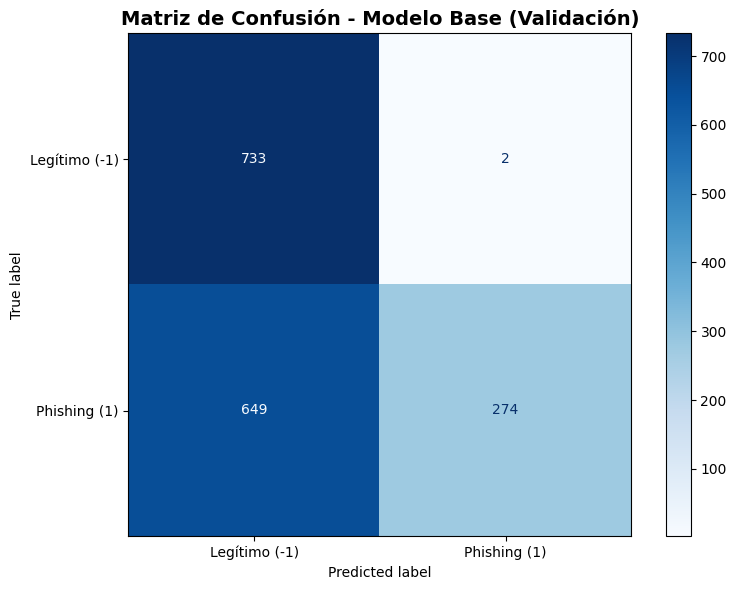


REPORTE DE CLASIFICACIÓN DETALLADO (VALIDACIÓN)
               precision    recall  f1-score   support

Legítimo (-1)       0.53      1.00      0.69       735
 Phishing (1)       0.99      0.30      0.46       923

     accuracy                           0.61      1658
    macro avg       0.76      0.65      0.57      1658
 weighted avg       0.79      0.61      0.56      1658



In [10]:
# ============================================
# Evaluación en el Conjunto de Validación
# ============================================

print("=" * 60)
print("EVALUACIÓN EN CONJUNTO DE VALIDACIÓN")
print("=" * 60)

# Predicciones en validación
y_pred_val_base = modelo_base.predict(X_val)

# Calcular métricas
acc_val_base = accuracy_score(y_val, y_pred_val_base)
prec_val_base = precision_score(y_val, y_pred_val_base)
rec_val_base = recall_score(y_val, y_pred_val_base)
f1_val_base = f1_score(y_val, y_pred_val_base)

print("\n📊 Métricas en Validación:")
print(f"  - Accuracy:  {acc_val_base:.4f} ({acc_val_base*100:.2f}%)")
print(f"  - Precision: {prec_val_base:.4f} ({prec_val_base*100:.2f}%)")
print(f"  - Recall:    {rec_val_base:.4f} ({rec_val_base*100:.2f}%)")
print(f"  - F1-Score:  {f1_val_base:.4f} ({f1_val_base*100:.2f}%)")

# Matriz de confusión
cm_val_base = confusion_matrix(y_val, y_pred_val_base)
print("\n📋 Matriz de Confusión (Validación):")
print(cm_val_base)
print(f"\n  TN (Verdaderos Negativos): {cm_val_base[0,0]} - Legítimos correctamente clasificados")
print(f"  FP (Falsos Positivos):     {cm_val_base[0,1]} - Legítimos marcados como phishing")
print(f"  FN (Falsos Negativos):     {cm_val_base[1,0]} - Phishing no detectado (⚠ RIESGO)")
print(f"  TP (Verdaderos Positivos): {cm_val_base[1,1]} - Phishing correctamente detectado")

# Visualización de matriz de confusión
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val_base, 
                               display_labels=['Legítimo (-1)', 'Phishing (1)'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('Matriz de Confusión - Modelo Base (Validación)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Reporte de clasificación detallado
print("\n" + "=" * 60)
print("REPORTE DE CLASIFICACIÓN DETALLADO (VALIDACIÓN)")
print("=" * 60)
print(classification_report(y_val, y_pred_val_base, 
                          target_names=['Legítimo (-1)', 'Phishing (1)']))


EVALUACIÓN EN CONJUNTO DE PRUEBA

📊 Métricas en Prueba:
  - Accuracy:  0.6052 (60.52%)
  - Precision: 0.9963 (99.63%)
  - Recall:    0.2922 (29.22%)
  - F1-Score:  0.4519 (45.19%)

📋 Matriz de Confusión (Prueba):
[[734   1]
 [654 270]]

  TN (Verdaderos Negativos): 734 - Legítimos correctamente clasificados
  FP (Falsos Positivos):     1 - Legítimos marcados como phishing
  FN (Falsos Negativos):     654 - Phishing no detectado (⚠ RIESGO)
  TP (Verdaderos Positivos): 270 - Phishing correctamente detectado


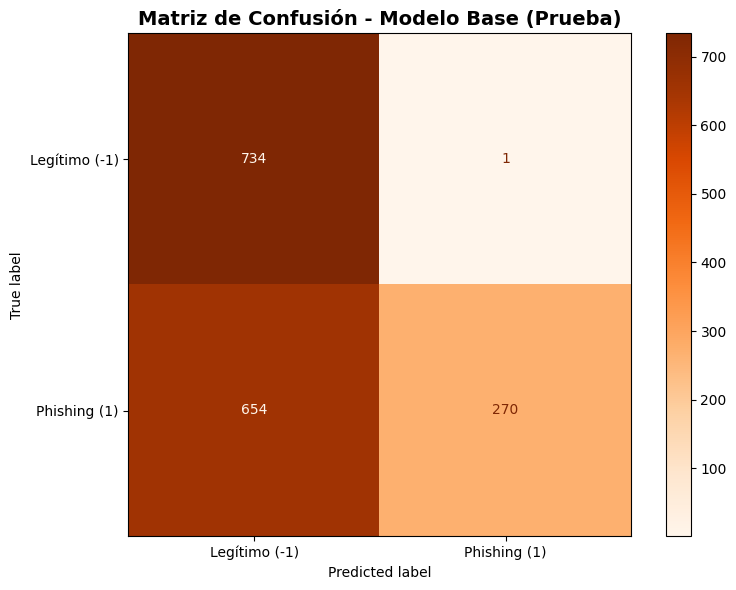


REPORTE DE CLASIFICACIÓN DETALLADO (PRUEBA)
               precision    recall  f1-score   support

Legítimo (-1)       0.53      1.00      0.69       735
 Phishing (1)       1.00      0.29      0.45       924

     accuracy                           0.61      1659
    macro avg       0.76      0.65      0.57      1659
 weighted avg       0.79      0.61      0.56      1659



In [11]:
# ============================================
# Evaluación en el Conjunto de Prueba
# ============================================

print("=" * 60)
print("EVALUACIÓN EN CONJUNTO DE PRUEBA")
print("=" * 60)

# Predicciones en prueba
y_pred_test_base = modelo_base.predict(X_test)

# Calcular métricas
acc_test_base = accuracy_score(y_test, y_pred_test_base)
prec_test_base = precision_score(y_test, y_pred_test_base)
rec_test_base = recall_score(y_test, y_pred_test_base)
f1_test_base = f1_score(y_test, y_pred_test_base)

print("\n📊 Métricas en Prueba:")
print(f"  - Accuracy:  {acc_test_base:.4f} ({acc_test_base*100:.2f}%)")
print(f"  - Precision: {prec_test_base:.4f} ({prec_test_base*100:.2f}%)")
print(f"  - Recall:    {rec_test_base:.4f} ({rec_test_base*100:.2f}%)")
print(f"  - F1-Score:  {f1_test_base:.4f} ({f1_test_base*100:.2f}%)")

# Matriz de confusión
cm_test_base = confusion_matrix(y_test, y_pred_test_base)
print("\n📋 Matriz de Confusión (Prueba):")
print(cm_test_base)
print(f"\n  TN (Verdaderos Negativos): {cm_test_base[0,0]} - Legítimos correctamente clasificados")
print(f"  FP (Falsos Positivos):     {cm_test_base[0,1]} - Legítimos marcados como phishing")
print(f"  FN (Falsos Negativos):     {cm_test_base[1,0]} - Phishing no detectado (⚠ RIESGO)")
print(f"  TP (Verdaderos Positivos): {cm_test_base[1,1]} - Phishing correctamente detectado")

# Visualización de matriz de confusión
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test_base,
                               display_labels=['Legítimo (-1)', 'Phishing (1)'])
disp.plot(ax=ax, cmap='Oranges', values_format='d')
ax.set_title('Matriz de Confusión - Modelo Base (Prueba)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Reporte de clasificación detallado
print("\n" + "=" * 60)
print("REPORTE DE CLASIFICACIÓN DETALLADO (PRUEBA)")
print("=" * 60)
print(classification_report(y_test, y_pred_test_base,
                          target_names=['Legítimo (-1)', 'Phishing (1)']))


In [12]:
# ============================================
# Comparación Validación vs Prueba (Modelo Base)
# ============================================

print("=" * 60)
print("COMPARACIÓN: VALIDACIÓN VS PRUEBA (MODELO BASE)")
print("=" * 60)

# Crear tabla comparativa
comparacion_base = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Validación': [acc_val_base, prec_val_base, rec_val_base, f1_val_base],
    'Prueba': [acc_test_base, prec_test_base, rec_test_base, f1_test_base],
    'Diferencia': [
        abs(acc_val_base - acc_test_base),
        abs(prec_val_base - prec_test_base),
        abs(rec_val_base - rec_test_base),
        abs(f1_val_base - f1_test_base)
    ]
})

print("\n")
display(comparacion_base.round(4))

# Interpretación
print("\n📝 Interpretación:")
diff_f1 = abs(f1_val_base - f1_test_base)
if diff_f1 < 0.02:
    print("✓ Excelente consistencia entre validación y prueba (diferencia F1 < 2%)")
elif diff_f1 < 0.05:
    print("✓ Buena consistencia entre validación y prueba (diferencia F1 < 5%)")
else:
    print("⚠ Diferencia notable entre validación y prueba - posible sobreajuste")

# Análisis de errores
print("\n📊 Análisis de Errores:")
fn_rate_val = cm_val_base[1,0] / (cm_val_base[1,0] + cm_val_base[1,1])
fp_rate_val = cm_val_base[0,1] / (cm_val_base[0,0] + cm_val_base[0,1])
fn_rate_test = cm_test_base[1,0] / (cm_test_base[1,0] + cm_test_base[1,1])
fp_rate_test = cm_test_base[0,1] / (cm_test_base[0,0] + cm_test_base[0,1])

print(f"  Validación:")
print(f"    - Tasa de Falsos Negativos (FN): {fn_rate_val*100:.2f}% - Phishing no detectado")
print(f"    - Tasa de Falsos Positivos (FP): {fp_rate_val*100:.2f}% - Falsas alarmas")
print(f"  Prueba:")
print(f"    - Tasa de Falsos Negativos (FN): {fn_rate_test*100:.2f}% - Phishing no detectado")
print(f"    - Tasa de Falsos Positivos (FP): {fp_rate_test*100:.2f}% - Falsas alarmas")

print("\n✓ Evaluación del modelo base completada")


COMPARACIÓN: VALIDACIÓN VS PRUEBA (MODELO BASE)




,Métrica,Validación,Prueba,Diferencia
0,Accuracy,0.6074,0.6052,0.0022
1,Precision,0.9928,0.9963,0.0036
2,Recall,0.2969,0.2922,0.0047
3,F1-Score,0.4570,0.4519,0.0052



📝 Interpretación:
✓ Excelente consistencia entre validación y prueba (diferencia F1 < 2%)

📊 Análisis de Errores:
  Validación:
    - Tasa de Falsos Negativos (FN): 70.31% - Phishing no detectado
    - Tasa de Falsos Positivos (FP): 0.27% - Falsas alarmas
  Prueba:
    - Tasa de Falsos Negativos (FN): 70.78% - Phishing no detectado
    - Tasa de Falsos Positivos (FP): 0.14% - Falsas alarmas

✓ Evaluación del modelo base completada


## 5. Fase 5: Optimización de Hiperparámetros con GridSearchCV

En esta fase optimizamos el hiperparámetro `var_smoothing` de GaussianNB usando GridSearchCV.

**var_smoothing**: Controla la estabilidad de la varianza en el cálculo de probabilidades
- Valores pequeños → modelo más sensible a los datos
- Valores grandes → modelo más estable

**Proceso**:
1. Definir espacio de búsqueda (valores logarítmicos de 1e-12 a 1e-6)
2. Configurar GridSearchCV con validación cruzada estratificada (5 folds)
3. Entrenar y seleccionar el mejor modelo según F1-score
4. Evaluar el modelo optimizado


In [ ]:
# ============================================
# Configuración de GridSearchCV
# ============================================

print("=" * 60)
print("OPTIMIZACIÓN DE HIPERPARÁMETROS - GRIDSEARCHCV")
print("=" * 60)

# Definir espacio de búsqueda para var_smoothing
param_grid = {
    'var_smoothing': np.logspace(-12, 0, 7)
}

print("\n📋 Espacio de búsqueda:")
print(f"   Hiperparámetro: var_smoothing")
print(f"   Valores a probar: {param_grid['var_smoothing']}")
print(f"   Total de combinaciones: {len(param_grid['var_smoothing'])}")

# Configurar validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=param_grid,
    scoring='f1',  # Métrica de optimización: F1-score
    cv=cv,
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=1
)

print("\n⚙ Configuración de GridSearchCV:")
print(f"   - Métrica de optimización: F1-score")
print(f"   - Validación cruzada: {cv.n_splits} folds estratificados")
print(f"   - Paralelización: Todos los núcleos (n_jobs=-1)")


OPTIMIZACIÓN DE HIPERPARÁMETROS - GRIDSEARCHCV

📋 Espacio de búsqueda:
   Hiperparámetro: var_smoothing
   Valores a probar: [1.e-12 1.e-11 1.e-10 1.e-09 1.e-08 1.e-07 1.e-06]
   Total de combinaciones: 7

⚙ Configuración de GridSearchCV:
   - Métrica de optimización: F1-score
   - Validación cruzada: 5 folds estratificados
   - Paralelización: Todos los núcleos (n_jobs=-1)


In [14]:
# ============================================
# Entrenamiento con GridSearchCV
# ============================================

print("\n" + "=" * 60)
print("ENTRENAMIENTO Y BÚSQUEDA DEL MEJOR MODELO")
print("=" * 60)

print("\n⏳ Ejecutando GridSearchCV...")
print("   (Esto puede tomar algunos segundos...)\n")

# Entrenar GridSearchCV con el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

print("\n✓ Búsqueda completada exitosamente")

# Obtener el mejor modelo
modelo_optimizado = grid_search.best_estimator_

print("\n" + "=" * 60)
print("RESULTADOS DE LA OPTIMIZACIÓN")
print("=" * 60)

print(f"\n🏆 Mejor hiperparámetro encontrado:")
print(f"   - var_smoothing: {grid_search.best_params_['var_smoothing']:.2e}")

print(f"\n📊 Mejor F1-score en validación cruzada:")
print(f"   - F1-Score promedio (CV): {grid_search.best_score_:.4f} ({grid_search.best_score_*100:.2f}%)")

# Mostrar todos los resultados
print("\n📋 Resultados de todos los valores probados:")
results_df = pd.DataFrame(grid_search.cv_results_)
results_summary = results_df[['param_var_smoothing', 'mean_test_score', 'std_test_score', 'rank_test_score']]
results_summary = results_summary.sort_values('rank_test_score')
results_summary.columns = ['var_smoothing', 'F1-Score (media)', 'F1-Score (std)', 'Ranking']
display(results_summary)



ENTRENAMIENTO Y BÚSQUEDA DEL MEJOR MODELO

⏳ Ejecutando GridSearchCV...
   (Esto puede tomar algunos segundos...)

Fitting 5 folds for each of 7 candidates, totalling 35 fits

✓ Búsqueda completada exitosamente

RESULTADOS DE LA OPTIMIZACIÓN

🏆 Mejor hiperparámetro encontrado:
   - var_smoothing: 1.00e-06

📊 Mejor F1-score en validación cruzada:
   - F1-Score promedio (CV): 0.6642 (66.42%)

📋 Resultados de todos los valores probados:


,var_smoothing,F1-Score (media),F1-Score (std),Ranking
6,1.000000e-06,0.664236,0.010686,1
5,1.000000e-07,0.588823,0.013541,2
4,1.000000e-08,0.510025,0.015504,3
3,1.000000e-09,0.452949,0.010057,4
2,1.000000e-10,0.418302,0.008634,5
1,1.000000e-11,0.395917,0.010101,6
0,1.000000e-12,0.384758,0.012885,7


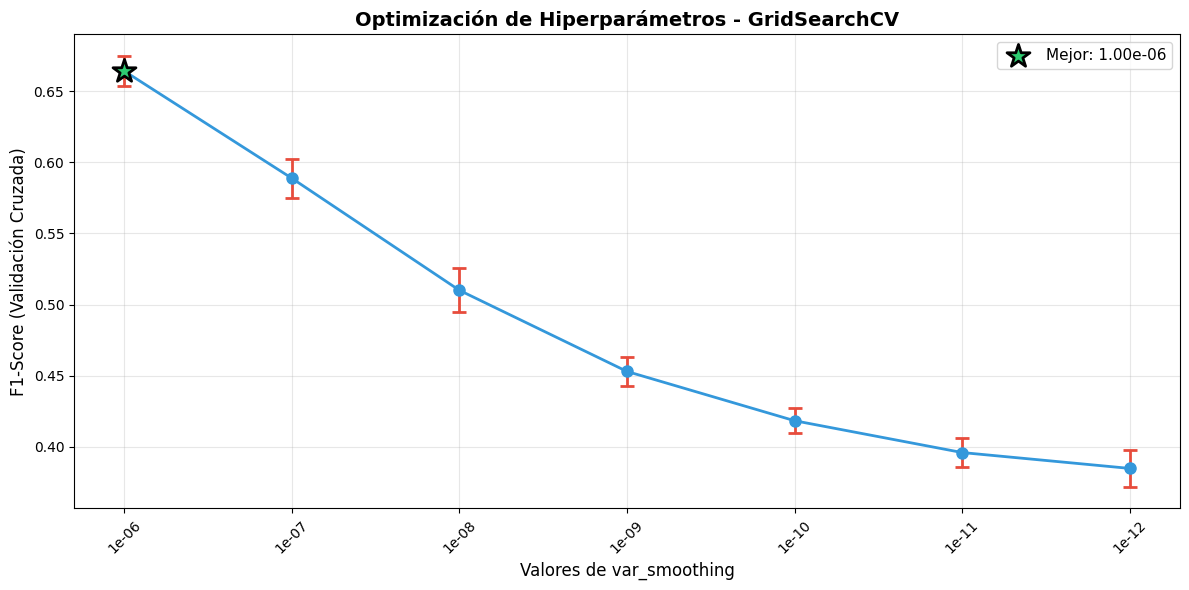

✓ Visualización completada


In [15]:
# ============================================
# Visualización de Resultados de GridSearchCV
# ============================================

# Graficar F1-score vs var_smoothing
fig, ax = plt.subplots(figsize=(12, 6))

var_smoothing_values = results_summary['var_smoothing'].values
f1_scores = results_summary['F1-Score (media)'].values
f1_std = results_summary['F1-Score (std)'].values

ax.errorbar(range(len(var_smoothing_values)), f1_scores, yerr=f1_std, 
            marker='o', markersize=8, capsize=5, capthick=2, 
            linewidth=2, color='#3498db', ecolor='#e74c3c')

# Marcar el mejor valor
best_idx = 0  # Ya está ordenado por ranking
ax.scatter(best_idx, f1_scores[best_idx], s=300, color='#2ecc71', 
           marker='*', edgecolors='black', linewidths=2, zorder=5,
           label=f'Mejor: {var_smoothing_values[best_idx]:.2e}')

ax.set_xlabel('Valores de var_smoothing', fontsize=12)
ax.set_ylabel('F1-Score (Validación Cruzada)', fontsize=12)
ax.set_title('Optimización de Hiperparámetros - GridSearchCV', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(var_smoothing_values)))
ax.set_xticklabels([f'{v:.0e}' for v in var_smoothing_values], rotation=45)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("✓ Visualización completada")


## 6. Evaluación del Modelo Optimizado

Ahora evaluamos el modelo con el mejor hiperparámetro encontrado por GridSearchCV en los conjuntos de validación y prueba.


EVALUACIÓN EN CONJUNTO DE VALIDACIÓN - MODELO OPTIMIZADO

📊 Métricas en Validación (Modelo Optimizado):
  - Accuracy:  0.7250 (72.50%)
  - Precision: 0.9937 (99.37%)
  - Recall:    0.5092 (50.92%)
  - F1-Score:  0.6734 (67.34%)

📋 Matriz de Confusión (Validación - Optimizado):
[[732   3]
 [453 470]]

  TN (Verdaderos Negativos): 732 - Legítimos correctamente clasificados
  FP (Falsos Positivos):     3 - Legítimos marcados como phishing
  FN (Falsos Negativos):     453 - Phishing no detectado (⚠ RIESGO)
  TP (Verdaderos Positivos): 470 - Phishing correctamente detectado


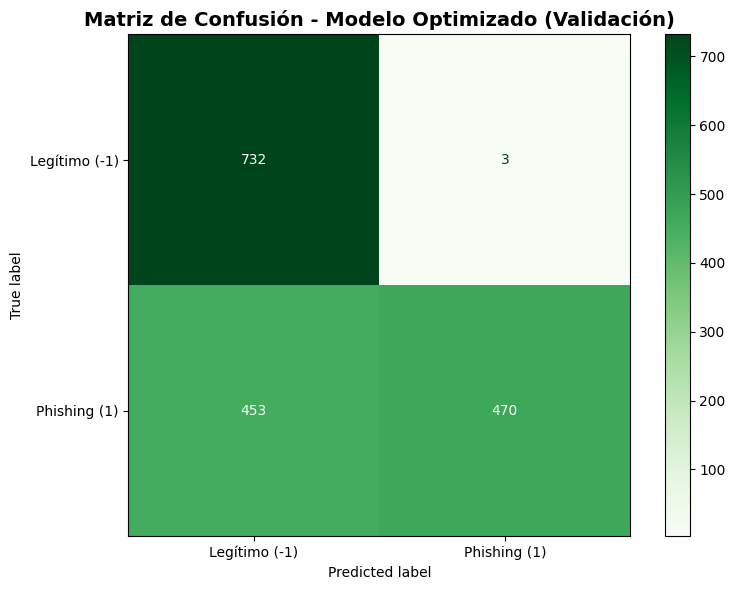


REPORTE DE CLASIFICACIÓN (VALIDACIÓN - OPTIMIZADO)
               precision    recall  f1-score   support

Legítimo (-1)       0.62      1.00      0.76       735
 Phishing (1)       0.99      0.51      0.67       923

     accuracy                           0.72      1658
    macro avg       0.81      0.75      0.72      1658
 weighted avg       0.83      0.72      0.71      1658



In [16]:
# ============================================
# Evaluación en Validación - Modelo Optimizado
# ============================================

print("=" * 60)
print("EVALUACIÓN EN CONJUNTO DE VALIDACIÓN - MODELO OPTIMIZADO")
print("=" * 60)

# Predicciones en validación
y_pred_val_opt = modelo_optimizado.predict(X_val)

# Calcular métricas
acc_val_opt = accuracy_score(y_val, y_pred_val_opt)
prec_val_opt = precision_score(y_val, y_pred_val_opt)
rec_val_opt = recall_score(y_val, y_pred_val_opt)
f1_val_opt = f1_score(y_val, y_pred_val_opt)

print("\n📊 Métricas en Validación (Modelo Optimizado):")
print(f"  - Accuracy:  {acc_val_opt:.4f} ({acc_val_opt*100:.2f}%)")
print(f"  - Precision: {prec_val_opt:.4f} ({prec_val_opt*100:.2f}%)")
print(f"  - Recall:    {rec_val_opt:.4f} ({rec_val_opt*100:.2f}%)")
print(f"  - F1-Score:  {f1_val_opt:.4f} ({f1_val_opt*100:.2f}%)")

# Matriz de confusión
cm_val_opt = confusion_matrix(y_val, y_pred_val_opt)
print("\n📋 Matriz de Confusión (Validación - Optimizado):")
print(cm_val_opt)
print(f"\n  TN (Verdaderos Negativos): {cm_val_opt[0,0]} - Legítimos correctamente clasificados")
print(f"  FP (Falsos Positivos):     {cm_val_opt[0,1]} - Legítimos marcados como phishing")
print(f"  FN (Falsos Negativos):     {cm_val_opt[1,0]} - Phishing no detectado (⚠ RIESGO)")
print(f"  TP (Verdaderos Positivos): {cm_val_opt[1,1]} - Phishing correctamente detectado")

# Visualización
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val_opt,
                               display_labels=['Legítimo (-1)', 'Phishing (1)'])
disp.plot(ax=ax, cmap='Greens', values_format='d')
ax.set_title('Matriz de Confusión - Modelo Optimizado (Validación)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Reporte de clasificación
print("\n" + "=" * 60)
print("REPORTE DE CLASIFICACIÓN (VALIDACIÓN - OPTIMIZADO)")
print("=" * 60)
print(classification_report(y_val, y_pred_val_opt,
                          target_names=['Legítimo (-1)', 'Phishing (1)']))


EVALUACIÓN EN CONJUNTO DE PRUEBA - MODELO OPTIMIZADO

📊 Métricas en Prueba (Modelo Optimizado):
  - Accuracy:  0.7113 (71.13%)
  - Precision: 0.9933 (99.33%)
  - Recall:    0.4848 (48.48%)
  - F1-Score:  0.6516 (65.16%)

📋 Matriz de Confusión (Prueba - Optimizado):
[[732   3]
 [476 448]]

  TN (Verdaderos Negativos): 732 - Legítimos correctamente clasificados
  FP (Falsos Positivos):     3 - Legítimos marcados como phishing
  FN (Falsos Negativos):     476 - Phishing no detectado (⚠ RIESGO)
  TP (Verdaderos Positivos): 448 - Phishing correctamente detectado


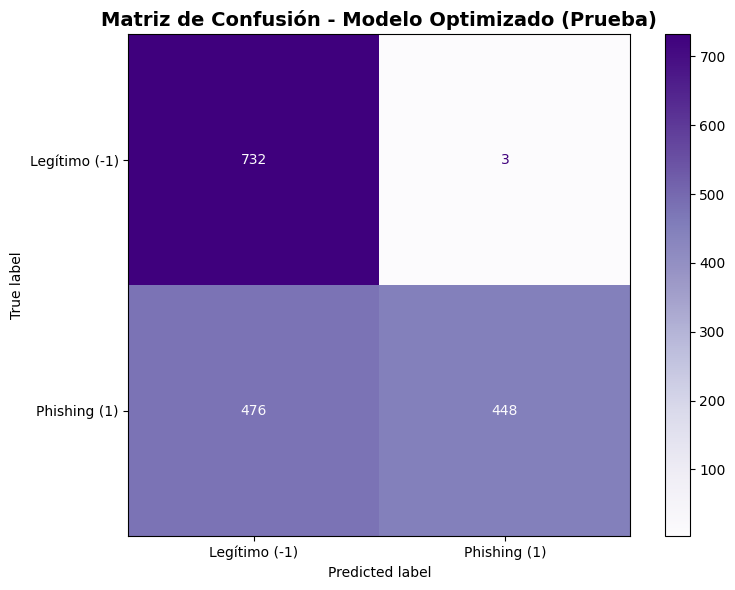


REPORTE DE CLASIFICACIÓN (PRUEBA - OPTIMIZADO)
               precision    recall  f1-score   support

Legítimo (-1)       0.61      1.00      0.75       735
 Phishing (1)       0.99      0.48      0.65       924

     accuracy                           0.71      1659
    macro avg       0.80      0.74      0.70      1659
 weighted avg       0.82      0.71      0.70      1659



In [17]:
# ============================================
# Evaluación en Prueba - Modelo Optimizado
# ============================================

print("=" * 60)
print("EVALUACIÓN EN CONJUNTO DE PRUEBA - MODELO OPTIMIZADO")
print("=" * 60)

# Predicciones en prueba
y_pred_test_opt = modelo_optimizado.predict(X_test)

# Calcular métricas
acc_test_opt = accuracy_score(y_test, y_pred_test_opt)
prec_test_opt = precision_score(y_test, y_pred_test_opt)
rec_test_opt = recall_score(y_test, y_pred_test_opt)
f1_test_opt = f1_score(y_test, y_pred_test_opt)

print("\n📊 Métricas en Prueba (Modelo Optimizado):")
print(f"  - Accuracy:  {acc_test_opt:.4f} ({acc_test_opt*100:.2f}%)")
print(f"  - Precision: {prec_test_opt:.4f} ({prec_test_opt*100:.2f}%)")
print(f"  - Recall:    {rec_test_opt:.4f} ({rec_test_opt*100:.2f}%)")
print(f"  - F1-Score:  {f1_test_opt:.4f} ({f1_test_opt*100:.2f}%)")

# Matriz de confusión
cm_test_opt = confusion_matrix(y_test, y_pred_test_opt)
print("\n📋 Matriz de Confusión (Prueba - Optimizado):")
print(cm_test_opt)
print(f"\n  TN (Verdaderos Negativos): {cm_test_opt[0,0]} - Legítimos correctamente clasificados")
print(f"  FP (Falsos Positivos):     {cm_test_opt[0,1]} - Legítimos marcados como phishing")
print(f"  FN (Falsos Negativos):     {cm_test_opt[1,0]} - Phishing no detectado (⚠ RIESGO)")
print(f"  TP (Verdaderos Positivos): {cm_test_opt[1,1]} - Phishing correctamente detectado")

# Visualización
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test_opt,
                               display_labels=['Legítimo (-1)', 'Phishing (1)'])
disp.plot(ax=ax, cmap='Purples', values_format='d')
ax.set_title('Matriz de Confusión - Modelo Optimizado (Prueba)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Reporte de clasificación
print("\n" + "=" * 60)
print("REPORTE DE CLASIFICACIÓN (PRUEBA - OPTIMIZADO)")
print("=" * 60)
print(classification_report(y_test, y_pred_test_opt,
                          target_names=['Legítimo (-1)', 'Phishing (1)']))


## 7. Comparación Final: Modelo Base vs Modelo Optimizado

En esta sección final comparamos el desempeño del modelo base (sin optimización) con el modelo optimizado (con GridSearchCV) para evaluar la mejora obtenida.


In [18]:
# ============================================
# Comparación de Métricas: Base vs Optimizado
# ============================================

print("=" * 70)
print("COMPARACIÓN COMPLETA: MODELO BASE vs MODELO OPTIMIZADO")
print("=" * 70)

# Tabla comparativa para el conjunto de VALIDACIÓN
print("\n" + "=" * 70)
print("CONJUNTO DE VALIDACIÓN")
print("=" * 70)

comparacion_val = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Modelo Base': [acc_val_base, prec_val_base, rec_val_base, f1_val_base],
    'Modelo Optimizado': [acc_val_opt, prec_val_opt, rec_val_opt, f1_val_opt],
    'Mejora': [
        acc_val_opt - acc_val_base,
        prec_val_opt - prec_val_base,
        rec_val_opt - rec_val_base,
        f1_val_opt - f1_val_base
    ],
    'Mejora %': [
        ((acc_val_opt - acc_val_base) / acc_val_base * 100) if acc_val_base != 0 else 0,
        ((prec_val_opt - prec_val_base) / prec_val_base * 100) if prec_val_base != 0 else 0,
        ((rec_val_opt - rec_val_base) / rec_val_base * 100) if rec_val_base != 0 else 0,
        ((f1_val_opt - f1_val_base) / f1_val_base * 100) if f1_val_base != 0 else 0
    ]
})

print("\n")
display(comparacion_val.round(4))

# Tabla comparativa para el conjunto de PRUEBA
print("\n" + "=" * 70)
print("CONJUNTO DE PRUEBA")
print("=" * 70)

comparacion_test = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Modelo Base': [acc_test_base, prec_test_base, rec_test_base, f1_test_base],
    'Modelo Optimizado': [acc_test_opt, prec_test_opt, rec_test_opt, f1_test_opt],
    'Mejora': [
        acc_test_opt - acc_test_base,
        prec_test_opt - prec_test_base,
        rec_test_opt - rec_test_base,
        f1_test_opt - f1_test_base
    ],
    'Mejora %': [
        ((acc_test_opt - acc_test_base) / acc_test_base * 100) if acc_test_base != 0 else 0,
        ((prec_test_opt - prec_test_base) / prec_test_base * 100) if prec_test_base != 0 else 0,
        ((rec_test_opt - rec_test_base) / rec_test_base * 100) if rec_test_base != 0 else 0,
        ((f1_test_opt - f1_test_base) / f1_test_base * 100) if f1_test_base != 0 else 0
    ]
})

print("\n")
display(comparacion_test.round(4))


COMPARACIÓN COMPLETA: MODELO BASE vs MODELO OPTIMIZADO

CONJUNTO DE VALIDACIÓN




,Métrica,Modelo Base,Modelo Optimizado,Mejora,Mejora %
0,Accuracy,0.6074,0.7250,0.1176,19.3644
1,Precision,0.9928,0.9937,0.0009,0.0910
2,Recall,0.2969,0.5092,0.2124,71.5328
3,F1-Score,0.4570,0.6734,0.2163,47.3266



CONJUNTO DE PRUEBA




,Métrica,Modelo Base,Modelo Optimizado,Mejora,Mejora %
0,Accuracy,0.6052,0.7113,0.1061,17.5299
1,Precision,0.9963,0.9933,-0.0030,-0.2973
2,Recall,0.2922,0.4848,0.1926,65.9259
3,F1-Score,0.4519,0.6516,0.1998,44.2047


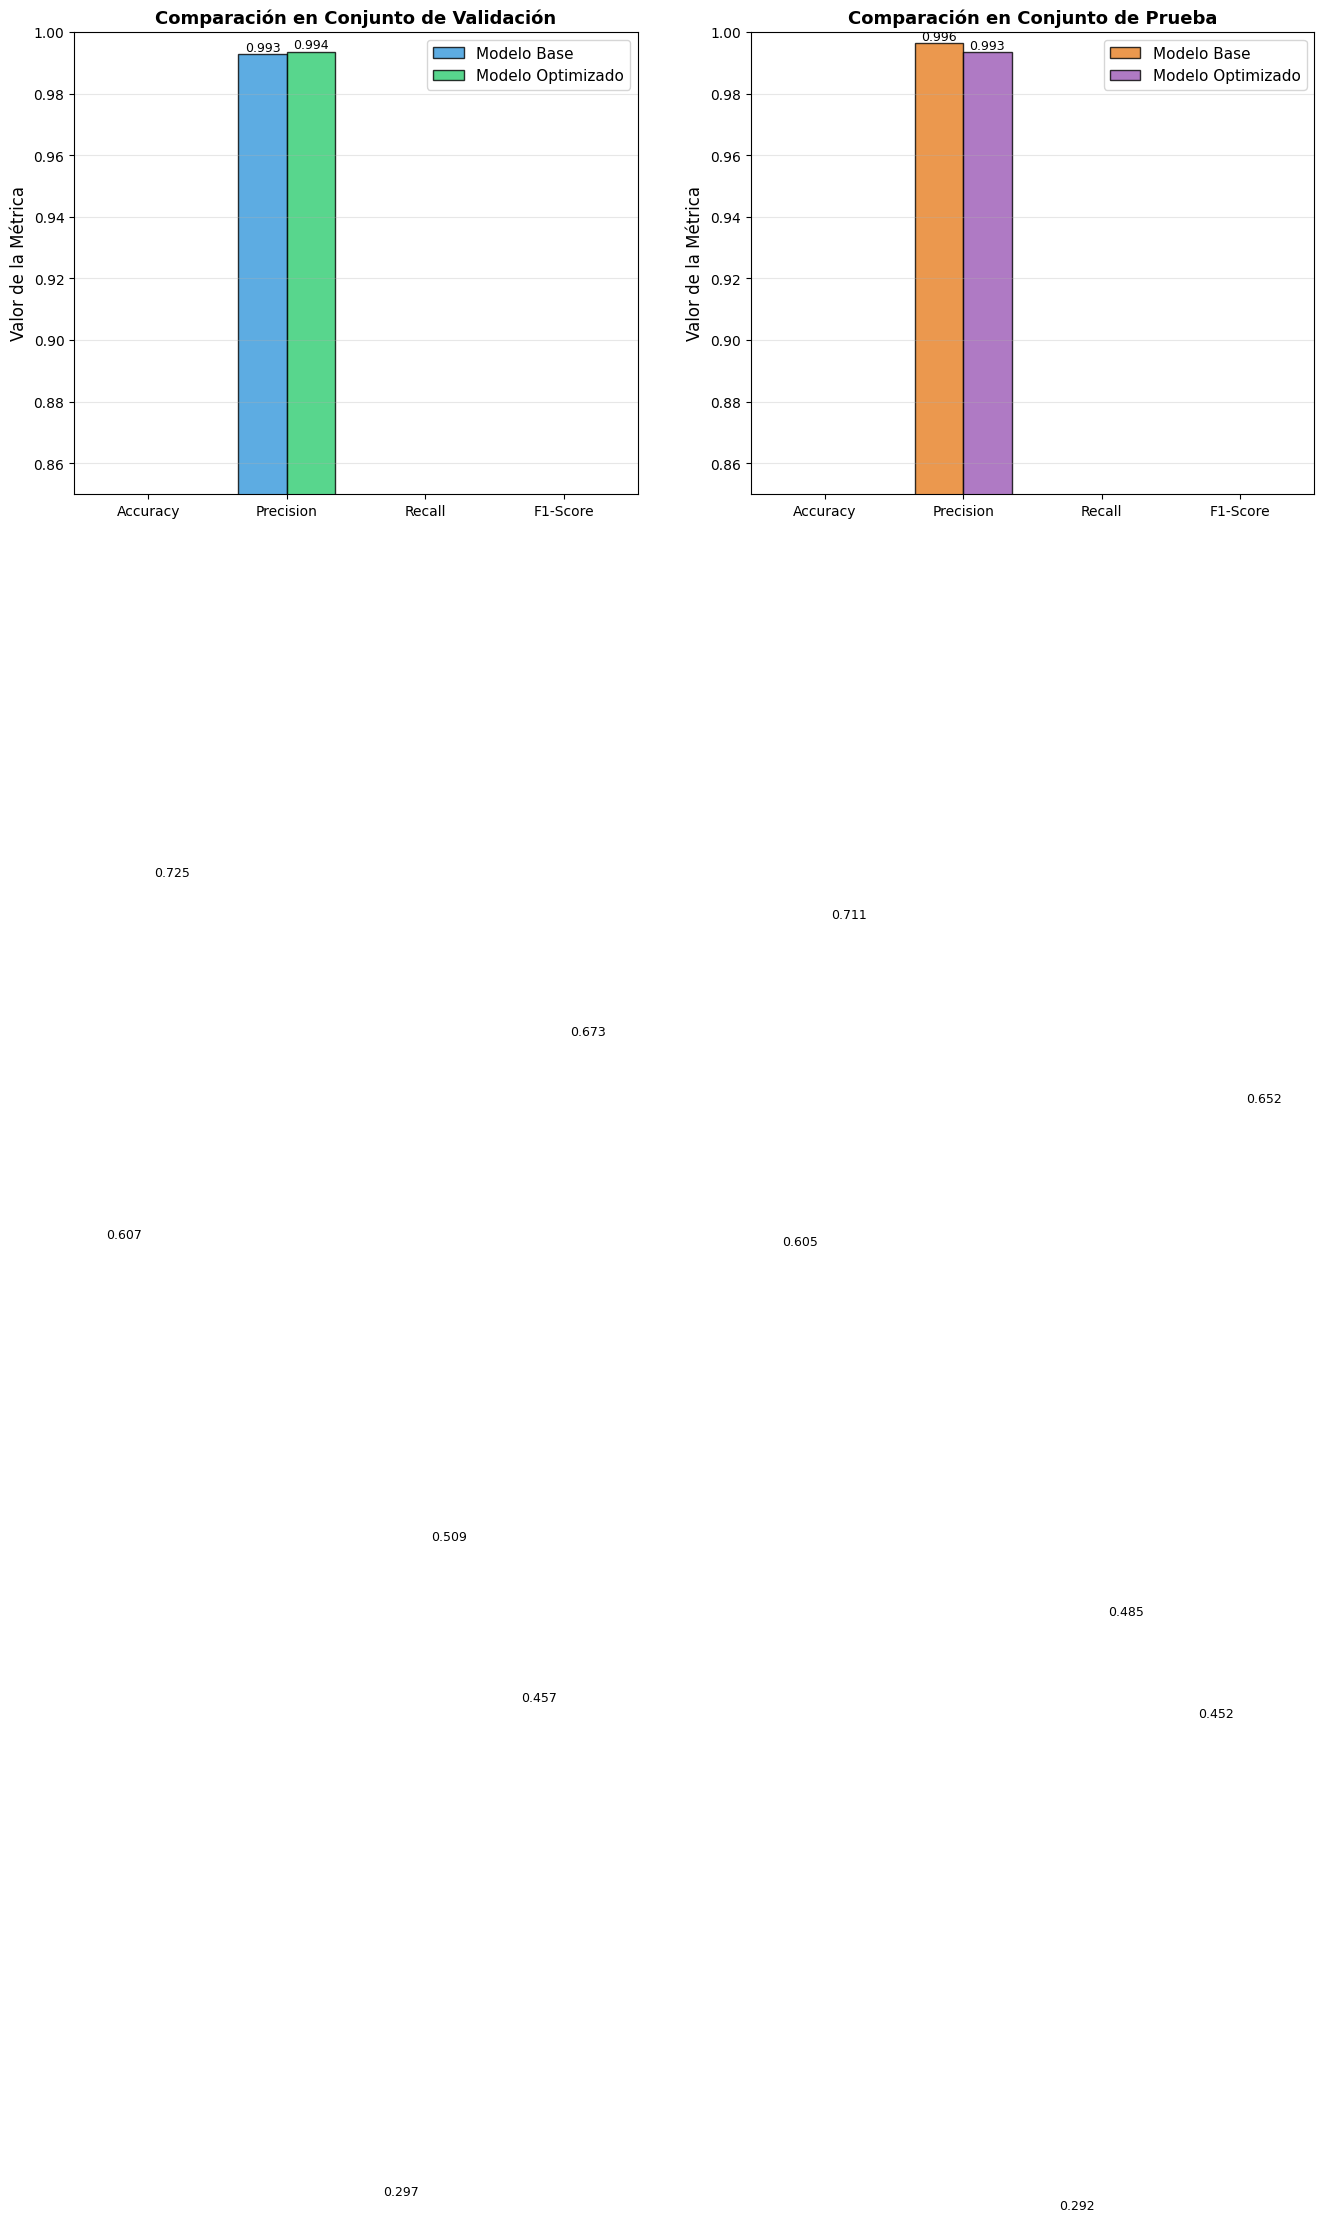

In [19]:
# ============================================
# Visualización Comparativa de Métricas
# ============================================

# Crear gráfico comparativo de barras
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Datos para validación
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
base_val = [acc_val_base, prec_val_base, rec_val_base, f1_val_base]
opt_val = [acc_val_opt, prec_val_opt, rec_val_opt, f1_val_opt]

# Datos para prueba
base_test = [acc_test_base, prec_test_base, rec_test_base, f1_test_base]
opt_test = [acc_test_opt, prec_test_opt, rec_test_opt, f1_test_opt]

x = np.arange(len(metricas))
width = 0.35

# Gráfico de validación
bars1 = axes[0].bar(x - width/2, base_val, width, label='Modelo Base', 
                    color='#3498db', alpha=0.8, edgecolor='black')
bars2 = axes[0].bar(x + width/2, opt_val, width, label='Modelo Optimizado',
                    color='#2ecc71', alpha=0.8, edgecolor='black')

axes[0].set_ylabel('Valor de la Métrica', fontsize=12)
axes[0].set_title('Comparación en Conjunto de Validación', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metricas)
axes[0].legend(fontsize=11)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.85, 1.0])

# Agregar valores en las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Gráfico de prueba
bars3 = axes[1].bar(x - width/2, base_test, width, label='Modelo Base',
                    color='#e67e22', alpha=0.8, edgecolor='black')
bars4 = axes[1].bar(x + width/2, opt_test, width, label='Modelo Optimizado',
                    color='#9b59b6', alpha=0.8, edgecolor='black')

axes[1].set_ylabel('Valor de la Métrica', fontsize=12)
axes[1].set_title('Comparación en Conjunto de Prueba', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metricas)
axes[1].legend(fontsize=11)
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0.85, 1.0])

# Agregar valores en las barras
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [20]:
# ============================================
# Análisis de Reducción de Errores
# ============================================

print("=" * 70)
print("ANÁLISIS DE REDUCCIÓN DE ERRORES")
print("=" * 70)

# Conjunto de Validación
fn_val_base = cm_val_base[1,0]
fp_val_base = cm_val_base[0,1]
fn_val_opt = cm_val_opt[1,0]
fp_val_opt = cm_val_opt[0,1]

# Conjunto de Prueba
fn_test_base = cm_test_base[1,0]
fp_test_base = cm_test_base[0,1]
fn_test_opt = cm_test_opt[1,0]
fp_test_opt = cm_test_opt[0,1]

print("\n📊 CONJUNTO DE VALIDACIÓN:")
print(f"\n  Falsos Negativos (FN) - Phishing no detectado:")
print(f"    - Modelo Base:       {fn_val_base}")
print(f"    - Modelo Optimizado: {fn_val_opt}")
print(f"    - Reducción:         {fn_val_base - fn_val_opt} ({((fn_val_base - fn_val_opt)/fn_val_base*100 if fn_val_base > 0 else 0):.2f}%)")

print(f"\n  Falsos Positivos (FP) - Falsas alarmas:")
print(f"    - Modelo Base:       {fp_val_base}")
print(f"    - Modelo Optimizado: {fp_val_opt}")
print(f"    - Reducción:         {fp_val_base - fp_val_opt} ({((fp_val_base - fp_val_opt)/fp_val_base*100 if fp_val_base > 0 else 0):.2f}%)")

print("\n" + "-" * 70)

print("\n📊 CONJUNTO DE PRUEBA:")
print(f"\n  Falsos Negativos (FN) - Phishing no detectado:")
print(f"    - Modelo Base:       {fn_test_base}")
print(f"    - Modelo Optimizado: {fn_test_opt}")
print(f"    - Reducción:         {fn_test_base - fn_test_opt} ({((fn_test_base - fn_test_opt)/fn_test_base*100 if fn_test_base > 0 else 0):.2f}%)")

print(f"\n  Falsos Positivos (FP) - Falsas alarmas:")
print(f"    - Modelo Base:       {fp_test_base}")
print(f"    - Modelo Optimizado: {fp_test_opt}")
print(f"    - Reducción:         {fp_test_base - fp_test_opt} ({((fp_test_base - fp_test_opt)/fp_test_base*100 if fp_test_base > 0 else 0):.2f}%)")


ANÁLISIS DE REDUCCIÓN DE ERRORES

📊 CONJUNTO DE VALIDACIÓN:

  Falsos Negativos (FN) - Phishing no detectado:
    - Modelo Base:       649
    - Modelo Optimizado: 453
    - Reducción:         196 (30.20%)

  Falsos Positivos (FP) - Falsas alarmas:
    - Modelo Base:       2
    - Modelo Optimizado: 3
    - Reducción:         -1 (-50.00%)

----------------------------------------------------------------------

📊 CONJUNTO DE PRUEBA:

  Falsos Negativos (FN) - Phishing no detectado:
    - Modelo Base:       654
    - Modelo Optimizado: 476
    - Reducción:         178 (27.22%)

  Falsos Positivos (FP) - Falsas alarmas:
    - Modelo Base:       1
    - Modelo Optimizado: 3
    - Reducción:         -2 (-200.00%)


In [21]:
# ============================================
# Resumen y Conclusiones Finales
# ============================================

print("\n" + "=" * 70)
print("RESUMEN Y CONCLUSIONES FINALES")
print("=" * 70)

print("\n🔍 CONFIGURACIÓN DEL PROYECTO:")
print(f"  - Dataset: Training Dataset.arff")
print(f"  - Total de muestras: {len(df):,}")
print(f"  - Número de features: 30")
print(f"  - Variable objetivo: Result (-1=Legítimo, 1=Phishing)")
print(f"  - División de datos: 70% train, 15% validación, 15% prueba")
print(f"  - Semilla aleatoria: {RANDOM_STATE}")

print("\n🔬 MODELO BASE:")
print(f"  - Algoritmo: Gaussian Naive Bayes")
print(f"  - var_smoothing: {modelo_base.var_smoothing:.2e} (por defecto)")
print(f"  - F1-Score en prueba: {f1_test_base:.4f}")

print("\n🚀 MODELO OPTIMIZADO:")
print(f"  - Método de optimización: GridSearchCV")
print(f"  - var_smoothing óptimo: {grid_search.best_params_['var_smoothing']:.2e}")
print(f"  - F1-Score en validación cruzada: {grid_search.best_score_:.4f}")
print(f"  - F1-Score en prueba: {f1_test_opt:.4f}")

print("\n📈 MEJORA OBTENIDA:")
mejora_f1 = f1_test_opt - f1_test_base
mejora_f1_pct = (mejora_f1 / f1_test_base * 100)
print(f"  - Mejora en F1-Score: {mejora_f1:+.4f} ({mejora_f1_pct:+.2f}%)")

if mejora_f1 > 0.01:
    print("  ✓ La optimización mejoró significativamente el desempeño")
elif mejora_f1 > 0:
    print("  ✓ La optimización mejoró ligeramente el desempeño")
else:
    print("  - La optimización no generó mejoras significativas")

print("\n⚠ ANÁLISIS DE RIESGOS:")
print(f"  - Falsos Negativos en prueba (Base): {fn_test_base}")
print(f"  - Falsos Negativos en prueba (Optimizado): {fn_test_opt}")
if fn_test_opt < fn_test_base:
    print(f"  ✓ Se redujo el riesgo de phishing no detectado en {fn_test_base - fn_test_opt} casos")
elif fn_test_opt > fn_test_base:
    print(f"  ⚠ Aumentó el riesgo de phishing no detectado en {fn_test_opt - fn_test_base} casos")
else:
    print("  - Sin cambios en falsos negativos")

print("\n" + "=" * 70)
print("✅ PROYECTO COMPLETADO EXITOSAMENTE")
print("=" * 70)

print("\n📝 PRÓXIMOS PASOS SUGERIDOS:")
print("  1. Probar otros algoritmos (Random Forest, SVM, etc.)")
print("  2. Realizar ingeniería de features")
print("  3. Probar técnicas de ensamble")
print("  4. Analizar importancia de features")
print("  5. Implementar validación en datos del mundo real")



RESUMEN Y CONCLUSIONES FINALES

🔍 CONFIGURACIÓN DEL PROYECTO:
  - Dataset: Training Dataset.arff
  - Total de muestras: 11,055
  - Número de features: 30
  - Variable objetivo: Result (-1=Legítimo, 1=Phishing)
  - División de datos: 70% train, 15% validación, 15% prueba
  - Semilla aleatoria: 42

🔬 MODELO BASE:
  - Algoritmo: Gaussian Naive Bayes
  - var_smoothing: 1.00e-09 (por defecto)
  - F1-Score en prueba: 0.4519

🚀 MODELO OPTIMIZADO:
  - Método de optimización: GridSearchCV
  - var_smoothing óptimo: 1.00e-06
  - F1-Score en validación cruzada: 0.6642
  - F1-Score en prueba: 0.6516

📈 MEJORA OBTENIDA:
  - Mejora en F1-Score: +0.1998 (+44.20%)
  ✓ La optimización mejoró significativamente el desempeño

⚠ ANÁLISIS DE RIESGOS:
  - Falsos Negativos en prueba (Base): 654
  - Falsos Negativos en prueba (Optimizado): 476
  ✓ Se redujo el riesgo de phishing no detectado en 178 casos

✅ PROYECTO COMPLETADO EXITOSAMENTE

📝 PRÓXIMOS PASOS SUGERIDOS:
  1. Probar otros algoritmos (Random Fore